# Emerging Topics -- AI

This code was created from Martha and Sean's emerging topic code and was used to create the hottest/coldest topics static graphics for the full, pandemics, and coronavirus corpora.

In [264]:
#%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns
import ast

import re

/home/scb8kw/.conda/envs/HT_Bert/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Data 

In [5]:
df = pd.read_csv("/home/scb8kw/git/dspg21RnD/data/dspg21RnD/Eads_AI_abstracts-KL.csv")# AI corpus

In [6]:
df

,index,original index,PROJECT_ID,ABSTRACT,FY,ORG_COUNT,PI_COUNT,nchar,final_frqwds_removed,PROJECT_TERMS,...,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,is_ai_eads
0,47,497627,64081,DESCRIPTION (provided by applicant): Healthy o...,2012,1,1,3104,"['healthy', 'older', 'listener', 'decline', 'c...",Acoustics; Address; Adult; Affect; aging brai...,...,IL,602013149,UNITED STATES,9/1/2012,1/1/2013,93.866,2012,142560.0,NaN,True
1,151,10470,100444,Magnetic fields on the Sun are ultimately the ...,2008,1,1,255,"['magnetic', 'sun', 'ultimately', 'source', 's...",magnetic field; Modeling; Source; The Sun; Un...,...,PA,19104-2875,UNITED STATES,NaN,NaN,43.001,2008,440000.0,NaN,True
2,206,1094356,1130812,PROJECT SUMMARY / ABSTRACTModern digital patho...,2019,1,1,3058,"['modern', 'digital', 'pathology', 'department...",actionable mutation; anticancer research; Arc...,...,NY,100654805,UNITED STATES,1/11/2019,1/10/2020,93.398,2019,45016.0,NaN,True
3,207,938623,931185,PROJECT SUMMARY / ABSTRACTModern digital patho...,2017,1,1,3059,"['modern', 'digital', 'pathology', 'department...",actionable mutation; anticancer research; Arc...,...,NY,100654805,UNITED STATES,1/11/2017,1/10/2018,93.398,2017,44044.0,NaN,True
4,249,999639,1085438,PROJECT SUMMARYWhile much is known about the m...,2017,1,1,2959,"['maintenance', 'memory', 'wm', 'prioritizeinf...",Aging; aging brain; Architecture; base; Bayes...,...,NY,100122300,UNITED STATES,9/12/2017,9/11/2018,93.867,2017,56694.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12689,690450,373718,694357,This contract task order provides support serv...,2010,1,1,170,"['contract', 'task', 'order', 'detection', 'lo...",Cancer Detection; Characteristics; Contracts;...,...,MD,208503304,UNITED STATES,NaN,NaN,NaN,2010,10780.0,NaN,True
12690,690643,315508,298903,DESCRIPTION (provided by applicant): We propos...,2010,1,1,3186,"['isolate', 'extract', 'individual', 'bioelect...",Acoustics; Algorithms; base; blind; Braces-Or...,...,MA,017301417,UNITED STATES,9/10/2010,9/9/2012,93.173,2010,161454.0,NaN,True
12691,690654,428413,461593,This subproject is one of many research subpro...,2011,1,1,326,"['multiseq', 'httpwwwscsuiuceduschultenmultise...",Bioinformatics; Biology; Computer software; c...,...,IL,618207406,UNITED STATES,8/1/2011,7/31/2012,93.389,2011,NaN,116046.0,True
12692,690726,331156,505303,DESCRIPTION (provided by applicant): Project D...,2013,1,1,1881,"['hyphy', 'httpwwwhyphyorg', 'scriptable', 'so...",acronyms; Amino Acids; Animal Model; Area; ba...,...,NC,276950001,UNITED STATES,9/1/2013,9/9/2015,93.859,2013,265099.0,NaN,True


In [7]:
docs = df["final_frqwds_removed"]

clean_docs = []
for doc in docs:
    doc = ast.literal_eval(doc)
    clean_docs.append(doc)

In [8]:
text = []

for abstract in clean_docs:
    text.append(" ".join(abstract))

In [9]:
text[0]

'healthy older listener decline cognitive speech_perception speech_perception real world listen highly variable speech sound phonem talker listen speech noise cognitive overarching newly test cognitive precede speech better real world speech communication healthy older adult ground decline compensation aging brain postulate decline sensory auditory_cortex compensate engagement general cognitive cortical region prefrontal_cortex cognitive expect pi r01 speech learn younger adult efficacy speech learning multi_talker variability sound word learning mediate cognitive brain region superior_parietal_lobule auditory attention prefrontal_cortex working memory purpose k02 award pi extend younger adult elderly population examination neurophysiological underpinnings efficacy prescribe cognitive multi__talker sound word speech noise decline compensation hypothesize engagement cognitive brain region post success speech learning issue concern older adult trend population seek cognitively stimulate 

### Functions needed for all models

In [10]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [11]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14
- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 30, random_state = 1

In [12]:
# use for full dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = tfidf_vectorizer.fit_transform(text)

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False)
tf_idf = tfidf_vectorizer.fit_transform(text)


In [13]:
# create model

num_topics = 30

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

/home/scb8kw/.conda/envs/HT_Bert/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


  Model time: 17.95438575744629


/home/scb8kw/.conda/envs/HT_Bert/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


### Emerging Topics

In [14]:
df['PROJECT_START_DATE']

0         9/1/2010
1        1/11/2008
2        1/11/2017
3        1/11/2017
4        9/12/2017
           ...    
12689    1/30/2005
12690    9/10/2010
12691     8/1/2011
12692    9/15/2010
12693    9/10/2018
Name: PROJECT_START_DATE, Length: 12694, dtype: object

In [15]:
from datetime import datetime
project_start_date = df["PROJECT_START_DATE"]
project_start_date = pd.to_datetime(project_start_date)
df["START_YEAR"] = project_start_date.dt.year
df = df[df.START_YEAR.notnull()]
sum(df['PROJECT_START_DATE'].isna())

0

In [16]:
df['START_YEAR'].value_counts(dropna=False)

2018.0    1630
2017.0    1206
2016.0    1107
2015.0     975
2009.0     936
2010.0     798
2014.0     793
2011.0     791
2012.0     748
2013.0     713
2008.0     653
2019.0     584
2007.0     180
2006.0      93
2004.0      86
2005.0      76
2000.0      38
2001.0      31
2002.0      30
1997.0      28
2003.0      27
1998.0      24
1992.0      20
1989.0      16
1995.0      16
1996.0      14
1991.0      11
1994.0      11
1999.0       9
1986.0       9
1990.0       7
1979.0       7
1988.0       7
1993.0       6
1984.0       4
1978.0       4
1977.0       4
1975.0       3
1987.0       3
1985.0       3
1976.0       1
1981.0       1
1983.0       1
1980.0       1
2020.0       1
Name: START_YEAR, dtype: int64

In [17]:
#Pulls sample data subsetted by year then takes mean theta for each abstract
topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]

In [18]:
topic_frame

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,START_YEAR
0,0.000000,0.039774,0.004324,0.002111,0.006700,0.106072,0.001631,0.000000,0.000000,0.000000,...,0.001580,0.000000,0.000000,0.049244,0.022524,0.006123,0.000000,0.000000,0.000000,2010.0
1,0.001216,0.001359,0.000000,0.000472,0.002064,0.000000,0.000000,0.000000,0.003199,0.000000,...,0.000392,0.001092,0.000671,0.001379,0.001077,0.001210,0.000348,0.004263,0.000000,2008.0
2,0.000000,0.000000,0.000000,0.000783,0.026450,0.000000,0.000000,0.025945,0.001156,0.000000,...,0.000000,0.000000,0.025553,0.000000,0.000073,0.000000,0.000000,0.002361,0.000000,2017.0
3,0.000000,0.000000,0.000000,0.000881,0.026254,0.000000,0.000000,0.026114,0.000175,0.000000,...,0.000000,0.000000,0.025819,0.000000,0.000043,0.000000,0.000000,0.002487,0.000000,2017.0
4,0.002388,0.000954,0.000000,0.000243,0.002005,0.000000,0.000000,0.001304,0.000000,0.000181,...,0.000000,0.000000,0.001760,0.001387,0.000000,0.000000,0.001331,0.001044,0.002434,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12689,0.000000,0.000000,0.000000,0.004872,0.000000,0.000000,0.000295,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000871,0.000000,0.000000,0.002492,0.000000,0.000000,2005.0
12690,0.000000,0.025825,0.000000,0.007134,0.004087,0.006056,0.000000,0.001885,0.000000,0.000000,...,0.029881,0.000000,0.000000,0.007177,0.001056,0.000778,0.000000,0.005646,0.000000,2010.0
12691,0.002529,0.001311,0.000000,0.003459,0.000000,0.000000,0.002810,0.000000,0.056644,0.000507,...,0.000000,0.000000,0.007105,0.000000,0.000000,0.000000,0.001155,0.002469,0.000000,2011.0
12692,0.002355,0.000143,0.003514,0.000000,0.001608,0.000000,0.000000,0.000000,0.023016,0.000000,...,0.000000,0.000000,0.049683,0.003551,0.000000,0.000000,0.004702,0.000000,0.000000,2010.0


### compute count of projects with weight > 0 for each topic

In [19]:
topic_proj_count = topic_frame.copy()

topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]


# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "START_YEAR")  # pretty sure this is unnecessary
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)

#topic counts
topic_counts_filt = topic_counts[topic_counts["START_YEAR"] > 2009] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] < 2019]  # NO NSF DATA from 2019, was 2020

topic_counts_filt


,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
34,2010,462,339,362,320,368,368,366,351,376,...,405,426,393,359,340,292,270,345,348,313
35,2011,458,316,347,321,392,343,397,336,335,...,418,383,377,315,311,286,291,332,341,273
36,2012,447,312,313,307,377,305,396,359,303,...,400,367,358,305,300,258,280,275,292,274
37,2013,428,274,292,310,329,261,428,316,306,...,396,379,336,266,280,242,247,268,281,245
38,2014,451,313,361,312,387,317,425,352,305,...,435,429,377,315,300,269,276,316,305,286
39,2015,595,355,412,394,479,400,545,419,369,...,504,504,481,368,391,345,367,358,400,366
40,2016,633,356,444,503,565,395,648,478,435,...,592,609,510,419,422,421,405,415,444,408
41,2017,698,446,471,506,635,461,705,509,457,...,674,682,577,490,441,498,435,508,486,483
42,2018,906,541,589,670,942,611,983,701,647,...,873,807,783,613,601,696,578,636,688,650


In [20]:
#TODO: counts by topic
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0     5078
Topic 1     3252
Topic 2     3591
Topic 3     3643
Topic 4     4474
Topic 5     3461
Topic 6     4893
Topic 7     3821
Topic 8     3533
Topic 9     4476
Topic 10    4870
Topic 11    3705
Topic 12    3270
Topic 13    2737
Topic 14    4812
Topic 15    3271
Topic 16    5699
Topic 17    3706
Topic 18    3374
Topic 19    5859
Topic 20    4697
Topic 21    4586
Topic 22    4192
Topic 23    3450
Topic 24    3386
Topic 25    3307
Topic 26    3149
Topic 27    3453
Topic 28    3585
Topic 29    3298
dtype: int64

### Calculate mean topic weight by year and standard errors on means

In [21]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2019] #TODO: change the upper limit to 2019

In [22]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [23]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
0,1975,0.000000,0.026839,0.028840,0.000000,0.005595,0.083522,0.000000,0.000000,0.000000,...,0.003137,0.004527,0.000000,0.000584,0.000000,0.000031,0.052229,0.000000,0.000000,0.000000
1,1976,0.000000,0.001140,0.000000,0.000000,0.000738,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.011489,0.000000,0.278490,0.000000,0.000000,0.000000,0.000000,0.000000
2,1977,0.000631,0.001420,0.000512,0.000000,0.000000,0.000143,0.055937,0.000000,0.003417,...,0.001855,0.000000,0.000000,0.007469,0.002184,0.000732,0.003394,0.001496,0.037821,0.005537
3,1978,0.000996,0.089380,0.002393,0.000089,0.000000,0.000387,0.000002,0.000919,0.000000,...,0.004404,0.001033,0.000166,0.000000,0.000000,0.000000,0.000000,0.000633,0.000000,0.050383
4,1979,0.000400,0.000105,0.110558,0.002699,0.001545,0.010204,0.000433,0.002017,0.000000,...,0.001739,0.002426,0.000111,0.000000,0.001256,0.000722,0.000220,0.000108,0.014256,0.009881


In [24]:
# filter topic_frame for years 2010 - 2018

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2019] #TODO: change the upper limit to 2019

In [25]:
# perform regressions, track slopes

topic_slopes = []

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    
    topic_slopes.append(linear_fit.coef_[0][0])

In [26]:
topic_slopes[:5]

[-0.00010752462387819128,
 -0.0005273430038081895,
 -0.000404025688856521,
 0.0002936473892039198,
 0.00030962572339455417]

In [27]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [28]:
hot_cold[:5]

['cold', 'cold', 'cold', 'hot', 'hot']

In [29]:
topic_words = str_topics(topic_term, tfidf_vectorizer, top_n=10)

In [30]:
topic_words[:5]

['statistical, dimensional, inference, variable, estimation, selection, statistic, methodology, parameter, theory',
 'auditory, sound, hearing, processing, auditory_cortex, temporal, acoustic, perception, listener, vocal',
 'language, linguistic, bilingual, sign, natural, processing, speaker, text, english, sentence',
 'robot, robotics, task, robotic, environment, manipulation, planning, manufacturing, autonomous, team',
 'patient, clinical, care, health, medical, nlp, healthcare, ehr, electronic, decision']

In [31]:
# package up data for data table in RShiny dashboard

reg_topics = pd.DataFrame()
reg_topics["Slope"] = topic_slopes
reg_topics["Hot or Cold"] = hot_cold
reg_topics["Topic Words"] = topic_words 


In [32]:
reg_topics

,Slope,Hot or Cold,Topic Words
0,-0.000108,cold,"statistical, dimensional, inference, variable,..."
1,-0.000527,cold,"auditory, sound, hearing, processing, auditory..."
2,-0.000404,cold,"language, linguistic, bilingual, sign, natural..."
3,0.000294,hot,"robot, robotics, task, robotic, environment, m..."
4,0.000310,hot,"patient, clinical, care, health, medical, nlp,..."
5,-0.000671,cold,"speech, recognition, speaker, production, acou..."
6,0.000441,hot,"student, conference, science, workshop, gradua..."
7,-0.000083,cold,"image, imaging, feature, text, segmentation, s..."
8,-0.000312,cold,"protein, sequence, prediction, interaction, dr..."
9,0.000351,hot,"network, node, dynamic, biological, wireless, ..."


In [33]:
#reg_topics.to_csv("./full_topics.csv", index=False)
#reg_topics.to_csv("./pan_topics.csv", index=False)
#reg_topics.to_csv("./cor_topics.csv", index=False)

## Create plot - top 5 hot and cold topics

In [34]:
# Sean's plots - legend

leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

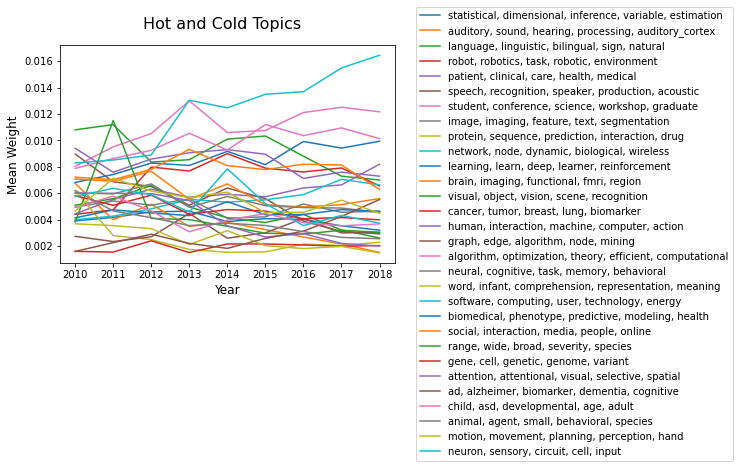

In [35]:
#Make Graphs
#leg = []
topic_results = {}
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    topic_results[i] = linear_fit.coef_[0][0]
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,i])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [36]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


In [37]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [38]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:5]]
bottom_slopes = [x[0] for x in sort_slopes[-5:]]

sort_slopes[:5]

[(20, 0.0010602678263230397),
 (7, 0.00044130525848052086),
 (26, 0.0003753701798621045),
 (11, 0.0003636666033398696),
 (10, 0.00035116226113447426)]

## Plot for each topic in a grid

In [39]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 1 to 30

# leg: indices 0-29

[20,
 7,
 26,
 11,
 10,
 17,
 5,
 4,
 16,
 14,
 21,
 22,
 8,
 1,
 29,
 15,
 27,
 18,
 24,
 19,
 12,
 30,
 9,
 13,
 28,
 3,
 23,
 2,
 25,
 6]

In [40]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx] + ' \n' + title[idx:])

In [41]:
new_leg

['statistical, dimensional, inference, \n variable, estimation',
 'auditory, sound, hearing, \n processing, auditory_cortex',
 'language, linguistic, bilingual, \n sign, natural',
 'robot, robotics, task, \n robotic, environment',
 'patient, clinical, care, \n health, medical',
 'speech, recognition, speaker, \n production, acoustic',
 'student, conference, science, \n workshop, graduate',
 'image, imaging, feature, \n text, segmentation',
 'protein, sequence, prediction, \n interaction, drug',
 'network, node, dynamic, \n biological, wireless',
 'learning, learn, deep, \n learner, reinforcement',
 'brain, imaging, functional, \n fmri, region',
 'visual, object, vision, \n scene, recognition',
 'cancer, tumor, breast, \n lung, biomarker',
 'human, interaction, machine, \n computer, action',
 'graph, edge, algorithm, \n node, mining',
 'algorithm, optimization, theory, \n efficient, computational',
 'neural, cognitive, task, \n memory, behavioral',
 'word, infant, comprehension, \n repr

# 10 topics

# 20 topics

# 30 topics 

### Descriptive statistics on corpus

In [42]:
df["START_YEAR"].value_counts()

2018.0    1630
2017.0    1206
2016.0    1107
2015.0     975
2009.0     936
2010.0     798
2014.0     793
2011.0     791
2012.0     748
2013.0     713
2008.0     653
2019.0     584
2007.0     180
2006.0      93
2004.0      86
2005.0      76
2000.0      38
2001.0      31
2002.0      30
1997.0      28
2003.0      27
1998.0      24
1992.0      20
1989.0      16
1995.0      16
1996.0      14
1991.0      11
1994.0      11
1999.0       9
1986.0       9
1990.0       7
1979.0       7
1988.0       7
1993.0       6
1984.0       4
1978.0       4
1977.0       4
1975.0       3
1987.0       3
1985.0       3
1976.0       1
1981.0       1
1983.0       1
1980.0       1
2020.0       1
Name: START_YEAR, dtype: int64

In [43]:
df["DEPARTMENT"].value_counts()

NSF     6788
HHS     4379
NASA     217
USDA     130
DOD       87
VA        63
ED        31
EPA       11
Name: DEPARTMENT, dtype: int64

In [44]:
# filter data frame by year and repeat descriptive statistics.  Limit years to those for emerging topic analysis.

filt_df = df.copy()
filt_df["START_YEAR"] = filt_df["START_YEAR"].astype('int')

filt_df = filt_df[filt_df["START_YEAR"] > 2009]
filt_df = filt_df[filt_df["START_YEAR"] < 2020]

In [45]:
filt_df["START_YEAR"].value_counts().sort_index()

2010     798
2011     791
2012     748
2013     713
2014     793
2015     975
2016    1107
2017    1206
2018    1630
2019     584
Name: START_YEAR, dtype: int64

In [46]:
filt_df["DEPARTMENT"].value_counts()

NSF     5900
HHS     3020
NASA     145
USDA      93
DOD       84
VA        62
ED        31
EPA       10
Name: DEPARTMENT, dtype: int64

In [47]:
filt_df.pivot_table(index=['DEPARTMENT','START_YEAR'], aggfunc='size')

DEPARTMENT  START_YEAR
DOD         2010           4
            2011           3
            2012           2
            2013           5
            2014           3
                          ..
VA          2015           6
            2016           6
            2017           3
            2018          11
            2019          16
Length: 70, dtype: int64